# Mini-Competition: One-Day Start to Finish Data Science Project

## The Task:
The task is to complete a full, start-to-finish data science project in one(ish) day, using the "best practice" skills we've learned over the past day of the course. 

## The Data:
The data shows real property information, including most recent sales price as of July 2018, for properties located Washington, D.C. The goal is to predict housing prices in DC. It is from [Kaggle](https://www.kaggle.com/christophercorrea/dc-residential-properties/version/7).

### Step 1: Exploration
- Explore the data and verify it, using tests of course! 
- At least 1 visualization of the data

### Step 2: Model Selection
- MUST use gridsearchCV in a pipeline!!

### Step 3: Production
- Once you've selected your desired model, put it (and the necessary feature engineering) in a pipeline. 
- Add at least 2 tests, including one for your final output!
- Bonus points if your predictor runs as its own python program from command line (rather than in a notebook).

Metric used to judge will be MAE (mean absolute error).
The team with the lowest MAE on the holdout test set at the end of Wednesday wins!

In [14]:
import pandas as pd
import numpy as np
import datetime

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import Imputer

In [17]:
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [19]:
filepath = "E:\Pascal\DSR\DataSets\DC_Properties.csv"
df = pd.read_csv(filepath, index_col=0, low_memory=False)

In [20]:
class ColumnSelector(BaseEstimator,TransformerMixin):
    
    def __init__(self, columns):
        self.columns = columns
    
    def transform(self, x):
        current_cols = list(set(self.columns) & set(x.columns))
        return x.loc[:,current_cols]
    
    def fit(self, x, y = None):
        return self

In [21]:
class RowNanReplacer(BaseEstimator,TransformerMixin):
    
    def __init__(self):
        pass   
    
    def transform(self, x):
        for col in x.columns:
            if x[col].dtype in [np.int64,np.int32,np.int16,np.int]:
                integer_mean = np.round(x[col].mean(),0).astype(x[col].dtype)
                val_dict = {col: integer_mean}
                x = x.fillna(val_dict)
            elif x[col].dtype in [np.float64,np.float32,np.float16,np.float]:
                float_mean = x[col].mean()
                val_dict = {col: float_mean}
                x = x.fillna(val_dict)
            else:
                most_freq = x[col].value_counts().idxmax()
                val_dict = {col: most_freq}
                x = x.fillna(val_dict)
        return x
    
    def fit(self, x, y = None):
        return self

In [22]:
class ColumnSelectorWithNanThreshold(BaseEstimator,TransformerMixin):
    
    def __init__(self, threshold):
        self.threshold = threshold
        
    
    def transform(self, x):
        self.columns = []
        for col in x.columns:
            if x[col].isna().sum() < self.threshold:
                self.columns.append(col)
        return x.loc[:,self.columns]
    
    def fit(self, x, y = None):
        return self

In [23]:
class ColumnSelectorWithCorrThreshold(BaseEstimator,TransformerMixin):
    
    def __init__(self, threshold):
        self.threshold = threshold
        
    
    def transform(self, x, verbose = False):
        self.removed_features = []
        self.corr = x.corr()
        self.columns = []
        
        for col in self.corr.columns:
            if col in self.removed_features:
                continue
            for row in list(self.corr[col].index):
                if row in self.removed_features:
                    continue
                if (row != col):
                    c = abs(self.corr[col][row])
                    if (c > self.threshold):
                        self.removed_features.append(row)
                        if verbose:
                            print("detected corr:",col,row,c)

        for col in x.columns:
            if col not in self.removed_features:
                self.columns.append(col)
                
        return x.loc[:,self.columns]
    
    def fit(self, x, y = None):
        return self

In [24]:
class DateToYearTranformer(BaseEstimator,TransformerMixin):
    
    def __init__(self, columns):
        self.columns = columns
        
    
    def transform(self, x):
        for col in self.columns:
            year_col = pd.to_datetime(x[col]).dt.year
            x.drop(columns = col, inplace = True)
            x[col] = year_col
        return x
    
    def fit(self, x, y = None):
        return self

In [29]:
discrete_col = ['BATHRM','HF_BATHRM','ROOMS','BEDRM','AYB','EYB','SALEDATE','FIREPLACES']
numeric_col = ['LATITUDE','LONGITUDE','CENSUS_TRACT','LANDAREA']
label_encode_column = ['HEAT','SALE_NUM','GIS_LAST_MOD_DTTM','SOURCE','ASSESSMENT_NBHD','USECODE','ZIPCODE','SQUARE','WARD']
one_hot_encode_column = ['QUALIFIED','AC','BLDG_NUM','QUADRANT']

In [26]:
df = pd.read_csv(filepath, index_col=0, low_memory=False)
print(df.shape)
df.drop(df[df['PRICE'].isnull()].index, inplace=True)
print(df.shape)
all_columns = list(df.columns)
target = df['PRICE']
features = df.drop('PRICE', axis=1)

(158957, 48)
(98216, 48)


In [27]:
from sklearn.pipeline import make_pipeline, make_union

In [30]:
# process the numeric and categorical columns.
# then, join them all together.

processing_pipeline = make_pipeline(
    # If using make_union, then we HAVE to first select all the columns we will pull from.
    
    #ColumnSelector(all_columns),
    ColumnSelectorWithNanThreshold(20000),
    ColumnSelectorWithCorrThreshold(0.9),
    RowNanReplacer(),
    DateToYearTranformer(["SALEDATE"]),
    
    make_union(
        # First, we select and 'hold out' the binary variables, as we wont do any further work to them.
        make_pipeline(ColumnSelector(discrete_col),
        ),
        # Pipeline for numeric features
        make_pipeline(
            ColumnSelector(numeric_col),
            StandardScaler()
        ),
        # Pipeline for label encoded features
        make_pipeline(
            ColumnSelector(label_encode_column),
            OrdinalEncoder()
        ),
        
        # Pipeline for one-hot-encoded features
        make_pipeline(
            ColumnSelector(one_hot_encode_column),
            OneHotEncoder()
        )
    )
)


In [32]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=10)

In [33]:
print(x_train.shape, y_train.shape)

(78572, 47) (78572,)


In [34]:
processed = processing_pipeline.fit_transform(features)
print("shape:",processed.shape)
print(type(processed))
print(type(processing_pipeline))

E:\Programme\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
E:\Programme\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


shape: (98216, 34)
<class 'numpy.ndarray'>
<class 'sklearn.pipeline.Pipeline'>


In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from math import sqrt
import matplotlib.pyplot as plt

In [36]:
finalpipeline = (
    
    make_pipeline(
        
        processing_pipeline, 
        
        RandomForestRegressor(
            random_state=1, 
            n_jobs=-1, 
            n_estimators=100
        )
    )
)
# Fitting the pipeline
print(type(finalpipeline))
finalpipeline.fit(x_train, y_train)
print(type(finalpipeline))

<class 'sklearn.pipeline.Pipeline'>


E:\Programme\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
E:\Programme\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


<class 'sklearn.pipeline.Pipeline'>


In [37]:
mean_price = df['PRICE'].mean()
print(mean_price)

931351.5949336156


In [38]:
def compare_predictions(x, y, finalpipeline, mean_target_value):
    # generate predictions:
    # Note: finalpipeline must have already been fit.
    
    predictions = finalpipeline.predict(x)
    y = y.reset_index()
    y.drop('index', axis=1, inplace=True)
    
    # a "lazy prediction" is where we return the average value of the target for every prediction.
    lazy_predictions = np.full(predictions.shape, mean_target_value)
    
    final_predictions = pd.DataFrame(pd.concat([y, 
                                                pd.Series(predictions), 
                                                pd.Series(lazy_predictions)], axis=1))
    final_predictions.rename(columns={'PRICE': 'True values',
                                      0: 'Predicted values',
                                      1: 'Lazy Predicted values'}, inplace=True)
    
    rmse_lazy = sqrt(mean_squared_error(y, lazy_predictions))
    mae_lazy = mean_absolute_error(y, lazy_predictions)
    r2_lazy = r2_score(y, lazy_predictions)
    
    rmse = sqrt(mean_squared_error(y, predictions))
    mae = mean_absolute_error(y, predictions)
    r2 = r2_score(y, predictions)
    
    print('RMSE Lazy Predictor', rmse_lazy)
    print('MAE Lazy Predictor', mae_lazy)
    print('R^2 Lazy Predictor', r2_lazy)
    print()
    print('RMSE', rmse)
    print('MAE', mae)
    print('R^2', r2)
    print()
    print('RMSE Improvement:', rmse_lazy - rmse)
    print('MAE Inprovement:', mae_lazy - mae)
    print('R^2 Improvement:', abs(r2_lazy - r2))
    
    
    plt.figure(figsize=(20,10))

    plt.plot(final_predictions.index, final_predictions['True values'], c='red', label='True Values')
    # plot a second data series 'Short students' in blue using the last three elements of x and y 
    plt.plot(final_predictions.index, final_predictions['Predicted values'], c='blue', label='Predicted Values')
    plt.plot(final_predictions.index, final_predictions['Lazy Predicted values'], c='black', label='Lazy Predicted Values')
    plt.legend(loc='best')
    plt.show()
    return predictions

E:\Programme\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


RMSE Lazy Predictor 6965908.553101111
MAE Lazy Predictor 940545.1560850014
R^2 Lazy Predictor -2.7906616772988002e-06

RMSE 628636.082225401
MAE 38050.65692334423
R^2 0.9918558777522866

RMSE Improvement: 6337272.47087571
MAE Inprovement: 902494.4991616572
R^2 Improvement: 0.9918586684139639


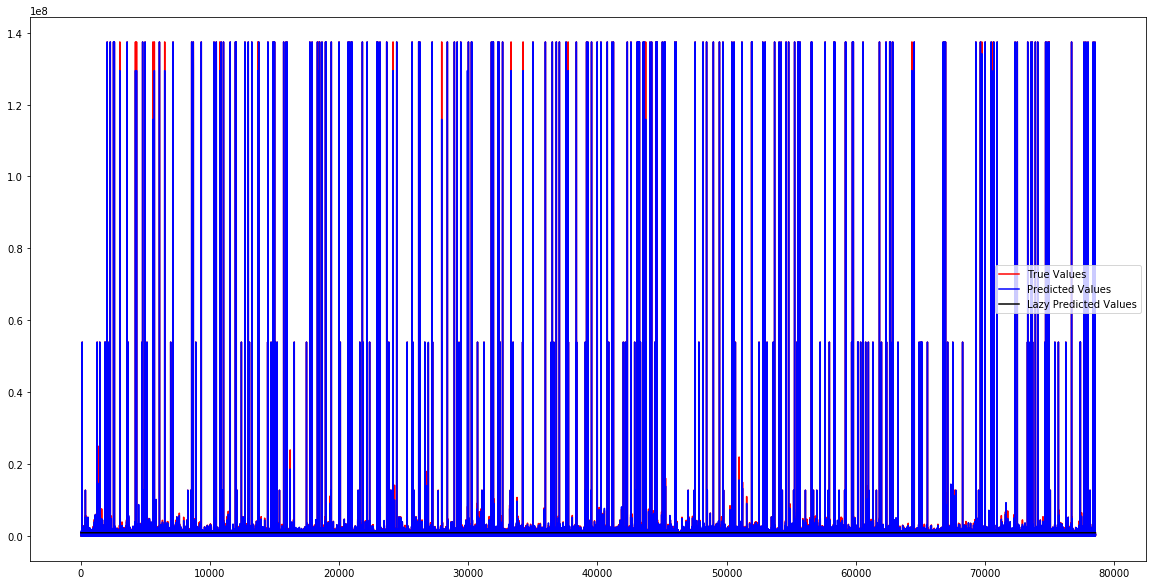

In [39]:
predictions_train = compare_predictions(x_train, y_train, finalpipeline, mean_price)

E:\Programme\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


RMSE Lazy Predictor 7430559.32814556
MAE Lazy Predictor 992866.9755342999
R^2 Lazy Predictor -3.923840159458791e-05

RMSE 1403017.2275440407
MAE 106443.73654508826
R^2 0.9643466751683788

RMSE Improvement: 6027542.100601519
MAE Inprovement: 886423.2389892116
R^2 Improvement: 0.9643859135699734


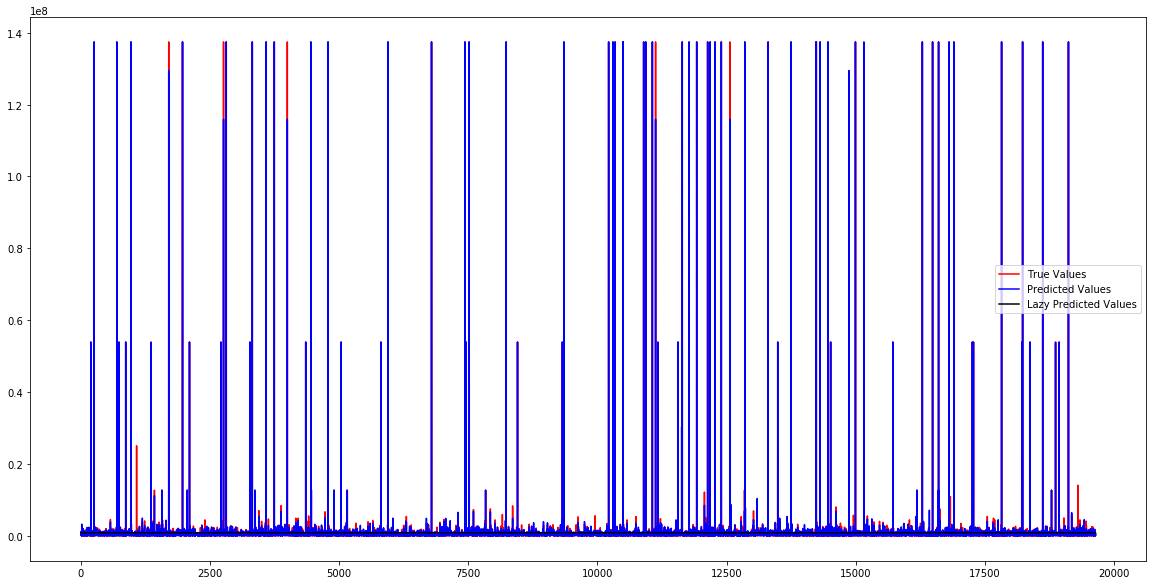

In [40]:
predictions_test = compare_predictions(x_test, y_test, finalpipeline, mean_price)

In [41]:
# Number of trees in random forest
n_estimators = [100, 500, 1000]
# Number of features to consider at every split
max_features = [5, 10, 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 110, num = 4)]
max_depth.append(None)

# Create the random grid
random_grid = {'randomforestregressor__n_estimators': n_estimators,
               'randomforestregressor__max_features': max_features,
               'randomforestregressor__max_depth': max_depth,
              }

random_grid = {'randomforestregressor__n_estimators': n_estimators,}
print(random_grid)

{'randomforestregressor__n_estimators': [100, 500, 1000]}


In [42]:
import sklearn
#from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [44]:
print("Grid search")
print('\n')

params = random_grid
scoring = 'neg_mean_absolute_error'
clf = GridSearchCV(finalpipeline, params, n_jobs=1, verbose=True, scoring=scoring)
clf.fit(x_train, y_train)

clf_preds = clf.predict(x_test)
clf_preds = pd.Series(clf_preds)
clf_preds = clf_preds.rename("Grid Search Predicted values")


#best_params = sorted(clf.grid_scores_, key=lambda x: -x[1])


Grid search


Fitting 3 folds for each of 3 candidates, totalling 9 fits


E:\Programme\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
E:\Programme\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
E:\Programme\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
E:\Programme\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)

E:\Programme\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [51]:
clf.cv_results_

E:\Programme\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
E:\Programme\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
E:\Programme\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
E:\Programme\Anaconda3\lib\site-packages\sklearn\utils\deprec

{'mean_fit_time': array([ 35.31963166, 171.81644058, 334.51834249]),
 'std_fit_time': array([0.50078296, 3.00783267, 5.09273325]),
 'mean_score_time': array([1.12249525, 3.43706512, 6.22920481]),
 'std_score_time': array([0.00780874, 0.11159259, 0.14930977]),
 'param_randomforestregressor__n_estimators': masked_array(data=[100, 500, 1000],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'randomforestregressor__n_estimators': 100},
  {'randomforestregressor__n_estimators': 500},
  {'randomforestregressor__n_estimators': 1000}],
 'split0_test_score': array([-104403.58549401, -100213.13654812,  -99847.65010182]),
 'split1_test_score': array([-96506.70429677, -96153.23335501, -96423.75707067]),
 'split2_test_score': array([-107286.52865624, -107417.57070403, -107525.09613443]),
 'mean_test_score': array([-102732.21485284, -101261.23518393, -101265.42143532]),
 'std_test_score': array([4556.76188301, 4657.96957887, 4641.6463764 ]),


In [ ]:
sorted(sklearn.metrics.SCORERS.keys())

In [ ]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, )
imp.fit([[1, 2], [np.nan, 3], [7, 6]])       
#SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean', verbose=0)
X = [[np.nan, 2], [6, np.nan], [7, 6]]
print(imp.transform(X))           